In [5]:
from typing import Annotated,Sequence
from typing_extensions import TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage
from langchain_core.messages import ToolMessage
from langchain_core.messages import HumanMessage,SystemMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode, tools_condition
load_dotenv()


True

In [8]:
from langchain_groq import ChatGroq
llm=ChatGroq(model='llama-3.3-70b-versatile')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000018923356D70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000018923354850>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
# load_dotenv
# llm = HuggingFaceEndpoint(
#     repo_id="microsoft/Phi-3-mini-4k-instruct",
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False,
#     repetition_penalty=1.03,
# )
# chat_model=ChatHuggingFace(llm=llm)

In [5]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

In [6]:
@tool
def add(a:int,b:int)->int:
    """Add two number"""
    return a+b
tools=[add]
model=llm.bind_tools(tools)

In [7]:
model

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002043B870E50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002043DE10580>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add two number', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [8]:
def model_call(state:AgentState)->AgentState:
    """call the agent"""
    system_prompt=    SystemMessage(content="You're a AI assistant, please answer my query to the best of your ability.")
    response=model.invoke([system_prompt]+state['messages'])
    return {'messages':response}

def should_continue(state:AgentState):  
    messages=state['messages']
    last_message=messages[-1]
    if not  last_message.tool_calls:
        return 'end'
    else:
        return 'continue'


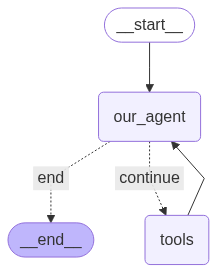

In [9]:
graph=StateGraph(AgentState)
graph.add_node('our_agent',model_call)
tool_node=ToolNode(tools=tools)
graph.add_node('tools',tool_node)
graph.set_entry_point('our_agent')
graph.add_conditional_edges('our_agent',
                            should_continue,
                            {'continue':'tools',
                             'end':END})
graph.add_edge('tools','our_agent')
app=graph.compile()
app

In [10]:
def print_stream(stream):
    for s in stream:
        message=s['messages'][-1]
        if isinstance(message,tuple):
            print(message)
        else:
            message.pretty_print()

In [11]:
input={'messages':["user","add 3+4"]}
print_stream(app.stream(input,stream_mode='values'))

================================ Human Message =================================

add 3+4
================================== Ai Message ==================================
Tool Calls:
  add (gdvytxbq5)
 Call ID: gdvytxbq5
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of 3+4 is 7.


In [12]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
# from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint


load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def add(a: int, b:int):
    """This is an addition function that adds 2 numbers together"""

    return a + b 

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

tools = [add, subtract, multiply]
# llm = HuggingFaceEndpoint(
#     repo_id="meta-llama/Llama-3.1-8B-Instruct",
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False,
#     repetition_penalty=1.03,
# )
# chat_model=ChatHuggingFace(llm=llm)

model = llm.bind_tools(tools)


def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"
    

graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)


tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "our_agent")

app = graph.compile()

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6.
================================== Ai Message ==================================
Tool Calls:
  add (42rymysrs)
 Call ID: 42rymysrs
  Args:
    a: 40
    b: 12
  multiply (bnyrht7c1)
 Call ID: bnyrht7c1
  Args:
    a: 52
    b: 6
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

The result of adding 40 and 12 is 52. Then, multiplying 52 by 6 gives 312.


## Basic Chatbot

In [3]:
from langchain_core.tools import tool
from typing_extensions import TypedDict
import pandas as pd
from langgraph.checkpoint.memory import InMemorySaver

bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002043B870E50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002043DE10580>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')) kwargs={'tools': [{'type': 'function', 'function': {'name': 'save_file', 'description': "Save text messages to a file named 'read.txt'.", 'parameters': {'properties': {'text': {'properties': {'messages': {'items': {}, 'type': 'array'}}, 'required': ['messages'], 'type': 'object'}}, 'required': ['text'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'add', 'description': 'This is an addition function that adds 2 numbers together', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'subtract', 'description': 'Subtraction function', 'parameters': {'properties': {'a': {'type':

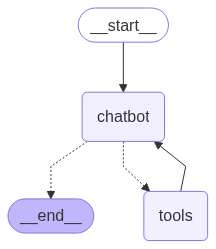

In [17]:
class AgentState(TypedDict):
    messages : Annotated[list,add_messages]

@tool
def save_file(text: AgentState):
    """Save text messages to a file named 'read.txt'."""
    with open('read.txt', 'w') as file:
        # Ensure each message ends with a newline
        lines = [msg if msg.endswith('\n') else msg + '\n' for msg in text['messages']]
        file.writelines(lines)
    return text



llm=llm.bind_tools([save_file,add,subtract,multiply])
print(llm)
def chatbot(state:AgentState):
    system_prompt=SystemMessage(content='You are a helpful AI assistant.')
    return {'messages':[llm.invoke([system_prompt]+state['messages'])]}
    



graph=StateGraph(AgentState)
graph.add_node("chatbot",chatbot)
graph.add_node('tools',ToolNode(tools=[save_file]))
graph.set_entry_point('chatbot')
graph.add_conditional_edges('chatbot',
                            tools_condition)
graph.add_edge('tools','chatbot')

checkpointer = InMemorySaver()
app = graph.compile(checkpointer=checkpointer)
app 

In [18]:
config = {"configurable": {"thread_id": 1}}
dssd=app.invoke({'messages':'add 5 and 32'},config)
for i in dssd['messages']:
    i.pretty_print()

================================ Human Message =================================

add 5 and 32
================================== Ai Message ==================================
Tool Calls:
  add (r2narmyvv)
 Call ID: r2narmyvv
  Args:
    a: 5
    b: 32
================================= Tool Message =================================
Name: add

Error: add is not a valid tool, try one of [save_file].
================================== Ai Message ==================================
Tool Calls:
  add (wg01enszh)
 Call ID: wg01enszh
  Args:
    a: 5
    b: 32
================================= Tool Message =================================
Name: add

Error: add is not a valid tool, try one of [save_file].
================================== Ai Message ==================================
Tool Calls:
  add (448yk9m6x)
 Call ID: 448yk9m6x
  Args:
    a: 5
    b: 32
================================= Tool Message =================================
Name: add

Error: add is not a valid tool, try one of 

## Agentic RAG

In [4]:
url="https://engineering.careers360.com/articles/jee-advanced-cutoff"


In [3]:
import pandas as pd

df=pd.read_html('https://engineering.careers360.com/articles/jee-advanced-cutoff',)
len(df)

25

In [5]:
import pandas as pd

def get_tables_from_urls(url_list):
    """
    Extract all tables from a list of URLs using pandas
    Returns a list of DataFrames
    """
    all_tables = []
    
    for url in url_list:
        try:
            # pandas.read_html returns a list of DataFrames
            tables = pd.read_html(url)
            print(f"Found {len(tables)} tables at {url}")
            all_tables.extend(tables)
        except Exception as e:
            print(f"Could not extract tables from {url}: {e}")
    
    return all_tables

# Example usage:
urls = [url]
tables = get_tables_from_urls(urls)

Found 25 tables at https://engineering.careers360.com/articles/jee-advanced-cutoff


In [6]:
def clean_tables(tables):
    """
    Clean the extracted tables with common pandas operations
    """
    cleaned = []
    
    for i, table in enumerate(tables):
        try:
            # Basic cleaning steps
            table = table.dropna(how='all')  # Drop completely empty rows
            table = table.dropna(axis=1, how='all')  # Drop completely empty columns
            table = table.fillna('')  # Fill remaining NaNs with empty strings
            
            # Convert all columns to string for consistent handling
            table = table.astype(str)
            
            # Add metadata about the table structure
            table.attrs['description'] = f"Table with {len(table)} rows and {len(table.columns)} columns"
            
            cleaned.append(table)
        except Exception as e:
            print(f"Error cleaning table {i}: {e}")
    
    return cleaned

cleaned_tables = clean_tables(tables)

In [10]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

In [ ]:
import pdfplumber
import pandas as pd
from langchain.schema import Document

pdf_path = "b7d2217256b11e333ac8ee3c90072ae1.pdf"
documents = []

with pdfplumber.open(pdf_path) as pdf:
    for i, page in enumerate(pdf.pages):
        text = page.extract_text()
        tables = page.extract_tables()

        for table in tables:
            df = pd.DataFrame(table[1:], columns=table[0])
            table_text = df.to_string(index=False)
            doc = Document(
                page_content=table_text,
                metadata={"source": pdf_path, "page": i + 1}
            )
            documents.append(doc)

# Example usage
print(documents[0].page_content[:500])

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    separators=["\n\n", "\n", " ", ""]
)

split_docs = splitter.split_documents(documents)
print(f"Split into {len(split_docs)} chunks.")
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vector_db = Chroma.from_documents(
    documents=split_docs,
    embedding=embeddings,
    persist_directory="./chroma_db")



                                                   Institute                                  Academic Program Name Quota Seat Type                                Gender Opening Rank Closing Rank
Dr. B R Ambedkar National Institute of Technology, Jalandhar       Bio Technology (4 Years, Bachelor of Technology)    HS      OPEN                        Gender-Neutral        62895        96223
Dr. B R Ambedkar National Institute of Technology, Jalandhar       Bio Technology (4 Years, Bachelor of Tech


In [13]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

e:\Projects\AI Agent\agentic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
vectordb = Chroma(persist_directory="chroma_db", embedding_function=embeddings)

retriever = vectordb.as_retriever()

# qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)

C:\Users\Aoutik Arya\AppData\Local\Temp\ipykernel_15544\1779906881.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(persist_directory="chroma_db", embedding_function=embeddings)


bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000018923356D70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000018923354850>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')) kwargs={'tools': [{'type': 'function', 'function': {'name': 'jee_college', 'description': 'Get Jee college details based on rank', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]} config={} config_factories=[]


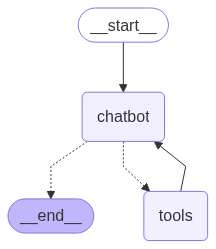

In [13]:
class AgentState(TypedDict):
    messages : Annotated[list,add_messages]

@tool
def save_file(text: AgentState):
    """Save text messages to a file named 'read.txt'."""
    with open('read.txt', 'w') as file:
        # Ensure each message ends with a newline
        lines = [msg if msg.endswith('\n') else msg + '\n' for msg in text['messages']]
        file.writelines(lines)
    return text

@tool
def jee_college(query:str):
    """Get Jee college details based on rank"""
    df=pd.read_html('https://engineering.careers360.com/articles/jee-advanced-cutoff')
    print(df)
    return df
    


llm=llm.bind_tools([jee_college])
print(llm)
def chatbot(state:AgentState):
    system_prompt=SystemMessage(content='You are a helpful AI college assistant.Try to give college name based on rank')
    return {'messages':[llm.invoke([system_prompt]+state['messages'])]}
    



graph=StateGraph(AgentState)
graph.add_node("chatbot",chatbot)
graph.add_node('tools',ToolNode(tools=[save_file]))
graph.set_entry_point('chatbot')
graph.add_conditional_edges('chatbot',
                            tools_condition)
graph.add_edge('tools','chatbot')

checkpointer = InMemorySaver()
app = graph.compile(checkpointer=checkpointer)
app 

In [14]:
config = {"configurable": {"thread_id": 1}}
response=app.invoke({"messages":"I got a rank of 2324 in jee advanced"},config)
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

I got a rank of 2324 in jee advanced
================================== Ai Message ==================================
Tool Calls:
  jee_college (jb4c5s26k)
 Call ID: jb4c5s26k
  Args:
    query: 2324
================================= Tool Message =================================
Name: jee_college

Error: jee_college is not a valid tool, try one of [save_file].
================================== Ai Message ==================================
Tool Calls:
  jee_college (1qq2gg09g)
 Call ID: 1qq2gg09g
  Args:
    query: 2324
================================= Tool Message =================================
Name: jee_college

Error: jee_college is not a valid tool, try one of [save_file].
================================== Ai Message ==================================
Tool Calls:
  jee_college (4ez67r0bm)
 Call ID: 4ez67r0bm
  Args:
    query: 2324
================================= Tool Message =================